In [ ]:
# https://unit8co.github.io/darts/generated_api/darts.models.forecasting.varima.html#darts.models.forecasting.varima.VARIMA

chec

In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Read a pandas DataFrame
aapl_df = pd.read_csv('AAPL.csv')
aapl_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
0,2016-01-04,25.65,26.34,25.50,26.34,24.44,270597600,0.070389,1133.0
1,2016-01-05,26.44,26.46,25.60,25.68,23.83,223164000,0.133635,1430.0
2,2016-01-06,25.14,25.59,24.97,25.17,23.36,273829600,0.072042,1949.0
3,2016-01-07,24.67,25.03,24.11,24.11,22.38,324377600,0.074369,2289.0
4,2016-01-08,24.64,24.78,24.19,24.24,22.50,283192000,0.051595,2235.0


In [31]:
aapl_df['Date'] = pd.to_datetime(aapl_df['Date'])
aapl_df.set_index('Date', inplace=True)

# Check for missing values in the dataset
missing_values = aapl_df.isnull().sum()
missing_values

Open                0
High                0
Low                 0
Close               0
Adj Close           0
Volume              0
ts_polarity       266
twitter_volume    266
dtype: int64

In [32]:
# Fill missing values with the last observed value (forward fill)
aapl_df.fillna(method='ffill', inplace=True)


C:\Users\TEO\AppData\Local\Temp\ipykernel_1468\2854147224.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aapl_df.fillna(method='ffill', inplace=True)


In [33]:
from sklearn.preprocessing import MinMaxScaler

# Define columns to scale
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ts_polarity', 'twitter_volume']

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the columns
aapl_df[columns_to_scale] = scaler.fit_transform(aapl_df[columns_to_scale])

In [34]:
# Splitting the data into training and validation sets
train_size = int(len(aapl_df) * 0.8)  # 80% for training
training_set = aapl_df.iloc[:train_size]
validation_set = aapl_df.iloc[train_size:]

In [38]:
from darts.models import VARIMA, RNNModel
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import GaussianLikelihood

In [42]:
# Assuming daily data, if your data is not daily, adjust 'D' to 'W' for weekly, etc.
frequency = 'D'  # Daily frequency

# Initialize the TimeSeries object with frequency handling
ts_close = TimeSeries.from_dataframe(training_set, value_cols=['Close', 'Volume'], fill_missing_dates=True, freq=frequency)

# Initialize the VARIMA model (Example parameters: p=12, d=0, q=0)
model_VARIMA = VARIMA(p=12, d=0, q=0, trend="n")

# Training the VARIMA model
model_VARIMA.fit(ts_close)

C:\Users\TEO\anaconda3\envs\chronos\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:373: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\TEO\anaconda3\envs\chronos\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARIMA(p=12, d=0, q=0, trend=n, add_encoders=None)

In [50]:
import darts
from darts.models import RNNModel

# Generate function to handle torch model configurations
def generate_torch_kwargs():
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [darts.utils.callbacks.TFMProgressBar(enable_train_bar_only=True)],
        }
    }

# Initialize the GRU model with some example parameters
model_GRU = RNNModel(
    model="LSTM",  # Using GRU instead of LSTM
    input_chunk_length=24,
    output_chunk_length=1,
    hidden_dim=25,
    n_rnn_layers=3,
    dropout=0.1,
    n_epochs=10,
    optimizer_kwargs={"lr": 1e-3},
    **generate_torch_kwargs()
)

frequency = 'D'  # Daily frequency

# Initialize the TimeSeries object with frequency handling
ts_close = TimeSeries.from_dataframe(training_set, value_cols=['Close', 'Volume'], fill_missing_dates=True, freq=frequency)

ts_features = TimeSeries.from_dataframe(training_set, value_cols=['Close', 'Volume'], fill_missing_dates=True, freq=frequency)

# Training the GRU model
model_GRU.fit([ts_features])

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 13.3 K
4 | V             | Linear           | 52    
---------------------------------------------------
13.4 K    Trainable params
0         Non-trainable params
13.4 K    Total params
0.053     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 43/43 [00:01<00:00, 32.53it/s, train_loss=nan.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 43/43 [00:01<00:00, 32.50it/s, train_loss=nan.0]


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=3, dropout=0.1, training_length=24, input_chunk_length=24, output_chunk_length=1, n_epochs=10, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x00000228E9514CD0>]})

In [51]:
# Both models are now trained. We will use the last 24 points from the training set to predict the validation set
forecast_length = len(validation_set)
forecast_VARIMA = model_VARIMA.predict(forecast_length)
forecast_GRU = model_GRU.predict(series=ts_features, n=forecast_length)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


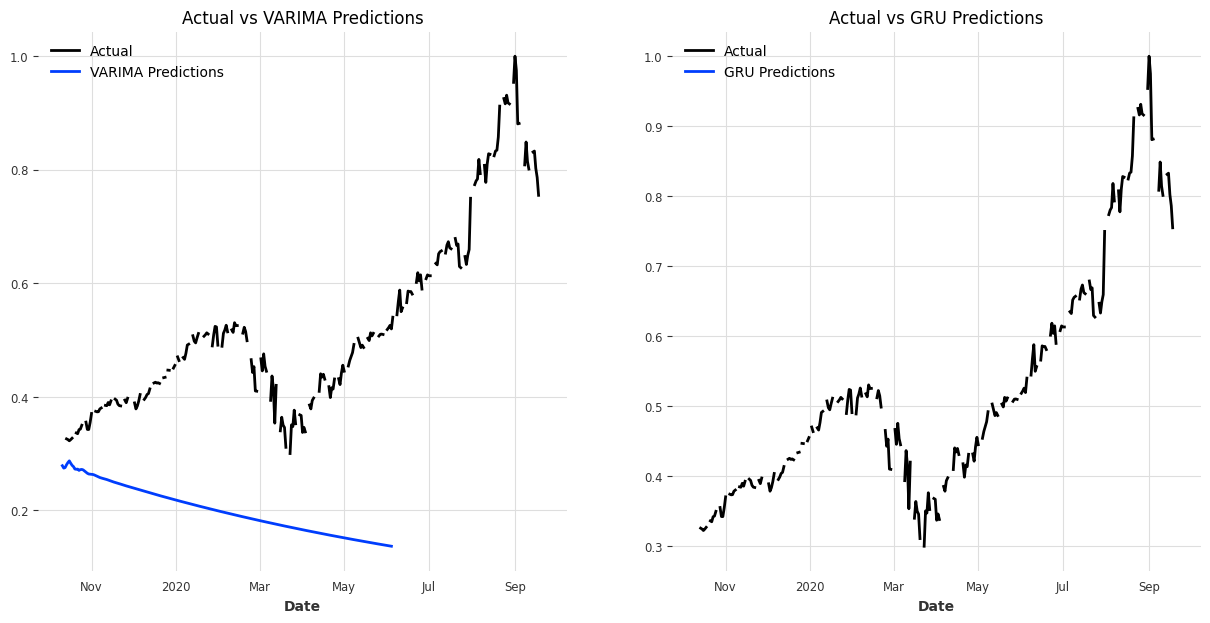

In [52]:
import matplotlib.pyplot as plt

# Convert validation set to TimeSeries for easy plotting
validation_ts = TimeSeries.from_dataframe(validation_set, value_cols=['Close', 'Volume'], fill_missing_dates=True, freq=frequency)

# Plotting the actual vs predicted values for VARIMA and GRU models
plt.figure(figsize=(15, 7))

# Actual data
plt.subplot(1, 2, 1)
validation_ts['Close'].plot(label='Actual')

# VARIMA predictions
forecast_VARIMA['Close'].plot(label='VARIMA Predictions')

plt.title('Actual vs VARIMA Predictions')
plt.legend()

# Actual data
plt.subplot(1, 2, 2)
validation_ts['Close'].plot(label='Actual')

# GRU predictions
forecast_GRU['Close'].plot(label='GRU Predictions')

plt.title('Actual vs GRU Predictions')
plt.legend()

plt.show()


In [18]:
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

multi_serie_elec = ElectricityDataset().load()

In [19]:
# retaining only three components in different ranges
retained_components = ["MT_002", "MT_008", "MT_009"]
multi_serie_elec = multi_serie_elec[retained_components]
# resampling the multivariate time serie
multi_serie_elec = multi_serie_elec.resample(freq="1H")
# keep the values for the last 5 days
multi_serie_elec = multi_serie_elec[-168:]

C:\Users\TEO\anaconda3\envs\chronos\Lib\site-packages\xarray\core\groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(


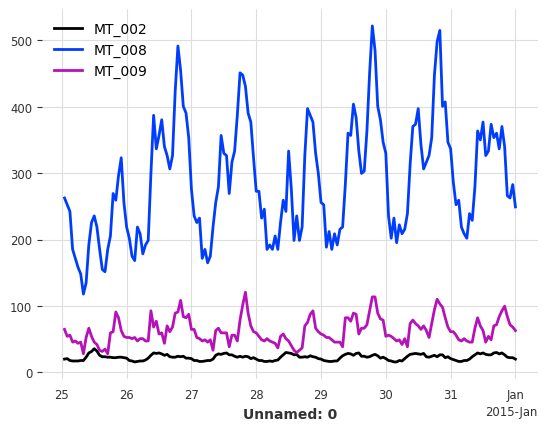

In [20]:
multi_serie_elec.plot()
plt.show()

In [22]:
from darts.dataprocessing.transformers import Scaler
# split in train/validation sets
training_set, validation_set = multi_serie_elec[:-24], multi_serie_elec[-24:]

# define a scaler, by default, normalize each component between 0 and 1
scaler_dataset = Scaler()
# scaler is fit on training set only to avoid leakage
training_scaled = scaler_dataset.fit_transform(training_set)
validation_scaled = scaler_dataset.transform(validation_set)


def fit_and_pred(model, training, validation):
    model.fit(training)
    forecast = model.predict(len(validation))
    return forecast

In [27]:
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.utils.callbacks import TFMProgressBar
from darts.metrics import mape, smape, mae
def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }
    
model_VARIMA = VARIMA(p=12, d=0, q=0, trend="n")

model_GRU = RNNModel(
    input_chunk_length=24,
    model="LSTM",
    hidden_dim=25,
    n_rnn_layers=3,
    training_length=36,
    n_epochs=200,
    **generate_torch_kwargs()
)

# training and prediction with the VARIMA model
forecast_VARIMA = fit_and_pred(model_VARIMA, training_scaled, validation_scaled)
print("MAE (VARIMA) = {:.2f}".format(mae(validation_scaled, forecast_VARIMA)))

# training and prediction with the RNN model
forecast_RNN = fit_and_pred(model_GRU, training_scaled, validation_scaled)
print("MAE (RNN) = {:.2f}".format(mae(validation_scaled, forecast_RNN)))

C:\Users\TEO\anaconda3\envs\chronos\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
GPU available: False, used: False


MAE (VARIMA) = 0.11


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 13.4 K
4 | V             | Linear           | 78    
---------------------------------------------------
13.5 K    Trainable params
0         Non-trainable params
13.5 K    Total params
0.054     Total estimated model params size (MB)


Epoch 199: 100%|██████████| 4/4 [00:00<00:00, 23.81it/s, train_loss=0.00759]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 4/4 [00:00<00:00, 23.53it/s, train_loss=0.00759]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


MAE (RNN) = 0.09


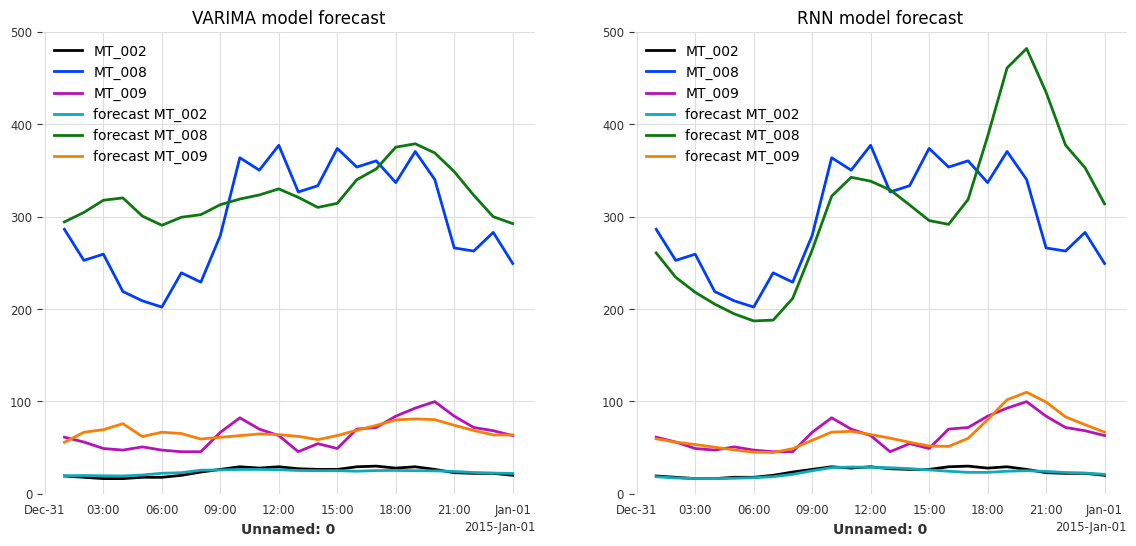

In [28]:
forecast_VARIMA = scaler_dataset.inverse_transform(forecast_VARIMA)
forecast_RNN = scaler_dataset.inverse_transform(forecast_RNN)

labels = [f"forecast {component}" for component in retained_components]
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
validation_set.plot(ax=axs[0])
forecast_VARIMA.plot(label=labels, ax=axs[0])
axs[0].set_ylim(0, 500)
axs[0].set_title("VARIMA model forecast")
axs[0].legend(loc="upper left")
validation_set.plot(ax=axs[1])
forecast_RNN.plot(label=labels, ax=axs[1])
axs[1].set_ylim(0, 500)
axs[1].set_title("RNN model forecast")
axs[1].legend(loc="upper left")
plt.show()